# ArXiv Pipeline Database Connectivity Testing

This notebook provides functionality to test connections to all databases used in the ArXiv Pipeline project:
- MongoDB (document storage)
- Neo4j (graph database)
- Qdrant (vector database)

Use this notebook to verify that all database connections are working properly and to explore basic database operations.

## Environment Setup

First, we'll install required packages if they're not already available and import necessary libraries.

In [74]:
# Install required packages if not available
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Map between pip package names and import names
def get_import_name(package):
    # Map pip package names to their import names
    name_mapping = {
        'python-dotenv': 'dotenv',
        'qdrant_client': 'qdrant_client',
        'ipywidgets': 'ipywidgets'
    }
    return name_mapping.get(package, package)

required_packages = [
    'pymongo',
    'neo4j',
    'qdrant_client',  # Already changed from 'qdrant-client' to 'qdrant_client'
    'pandas',
    'matplotlib',
    'ipywidgets',
    'python-dotenv'
]

for package in required_packages:
    try:
        # Get the correct import name for the package
        import_name = get_import_name(package)
        __import__(import_name)
        print(f"✅ {package} is already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        install_package(package)
        print(f"✅ {package} installed successfully")

✅ pymongo is already installed
✅ neo4j is already installed
✅ qdrant_client is already installed
✅ pandas is already installed
✅ matplotlib is already installed
✅ ipywidgets is already installed
✅ python-dotenv is already installed


In [75]:
# Import required libraries
import os
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from neo4j import GraphDatabase
from qdrant_client import QdrantClient
from dotenv import load_dotenv

# Load environment variables from .env file (if present)
load_dotenv()

# Set Matplotlib config
%matplotlib inline
plt.style.use('ggplot')

## Configuration

We'll set up default connection parameters and allow for customization via environment variables.

In [76]:
# MongoDB Configuration
MONGO_URI = os.getenv("MONGO_URI", "mongodb://localhost:27017/")
MONGO_DB = os.getenv("MONGO_DB", "arxiv_papers")

# Neo4j Configuration
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "password")

# Qdrant Configuration
QDRANT_URI = os.getenv("QDRANT_URI", "localhost")
QDRANT_PORT = int(os.getenv("QDRANT_PORT", "6333"))

print("Current configurations:")
print(f"MongoDB URI: {MONGO_URI}")
print(f"MongoDB Database: {MONGO_DB}")
print(f"Neo4j URI: {NEO4J_URI}")
print(f"Neo4j User: {NEO4J_USER}")
print(f"Qdrant URI: {QDRANT_URI}:{QDRANT_PORT}")

Current configurations:
MongoDB URI: mongodb://localhost:27017/
MongoDB Database: arxiv_papers
Neo4j URI: bolt://localhost:7687
Neo4j User: neo4j
Qdrant URI: localhost:6333


## 1. MongoDB Connectivity Test

Let's test the connection to MongoDB, which is used for storing paper metadata and other structured data.

In [77]:
def test_mongodb_connection():
    """Test connection to MongoDB and return client if successful"""
    try:
        # Create a MongoDB client
        client = MongoClient(MONGO_URI, serverSelectionTimeoutMS=5000)
        
        # Verify connection by getting server info
        server_info = client.server_info()
        
        print(f"✅ Successfully connected to MongoDB")
        
        # Check if server_info is a dictionary or string
        if isinstance(server_info, dict):
            print(f"Server version: {server_info.get('version')}")
            if 'sysInfo' in server_info and 'hostInfo' in server_info['sysInfo']:
                print(f"Server: {server_info['sysInfo']['hostInfo'].get('system', '')}")
        else:
            print(f"Server version: {server_info}")
        
        return client
    except Exception as e:
        print(f"❌ Failed to connect to MongoDB: {e}")
        return None

# Test MongoDB connection
mongo_client = test_mongodb_connection()

✅ Successfully connected to MongoDB
Server version: 8.0.8


In [78]:
# If connection was successful, list available databases and collections
if mongo_client:
    try:
        # List databases
        print("Available databases:")
        databases = mongo_client.list_database_names()
        for db in databases:
            print(f"- {db}")
        
        # Access the ArXiv database and list collections
        if MONGO_DB in databases:
            db = mongo_client[MONGO_DB]
            print(f"\nCollections in '{MONGO_DB}' database:")
            collections = db.list_collection_names()
            for collection in collections:
                print(f"- {collection} ({db[collection].count_documents({})} documents)")
        else:
            print(f"\nDatabase '{MONGO_DB}' not found. This might be expected if you haven't run the pipeline yet.")
    except Exception as e:
        print(f"Error exploring MongoDB: {e}")

Available databases:
- admin
- arxiv_papers
- config
- local

Collections in 'arxiv_papers' database:
- ingestion_stats (2551 documents)
- papers (26141 documents)
- processed_pdfs (17 documents)


## 2. Neo4j Connectivity Test

Now, let's test the connection to Neo4j, which is used for graph representation of papers, authors, and categories.

In [79]:
def test_neo4j_connection():
    """Test connection to Neo4j and return driver if successful"""
    try:
        # Create a Neo4j driver instance
        driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
        
        # Verify connection by running a simple query
        with driver.session() as session:
            result = session.run("RETURN 'Connection successful' AS message, 1 AS test_value")
            record = result.single()
            print(f"✅ {record['message']} to Neo4j")
            
            # Get Neo4j version
            version_result = session.run("CALL dbms.components() YIELD name, versions, edition RETURN name, versions, edition")
            version_record = version_result.single()
            print(f"Neo4j version: {version_record['versions'][0]} {version_record['edition']}")
        
        return driver
    except Exception as e:
        print(f"❌ Failed to connect to Neo4j: {e}")
        return None

# Test Neo4j connection
neo4j_driver = test_neo4j_connection()

✅ Connection successful to Neo4j
Neo4j version: 5.27.0 community


Node counts by type:
- Author: 75315 nodes
- Paper: 26142 nodes
- Person: 417 nodes
- Category: 143 nodes
- Movie: 120 nodes

Relationship counts by type:
- AUTHORED: 216052 relationships
- IN_CATEGORY: 52282 relationships
- ACTED_IN: 1080 relationships
- DIRECTED: 264 relationships
- PRODUCED: 84 relationships
- WROTE: 54 relationships
- REVIEWED: 48 relationships
- FOLLOWS: 18 relationships


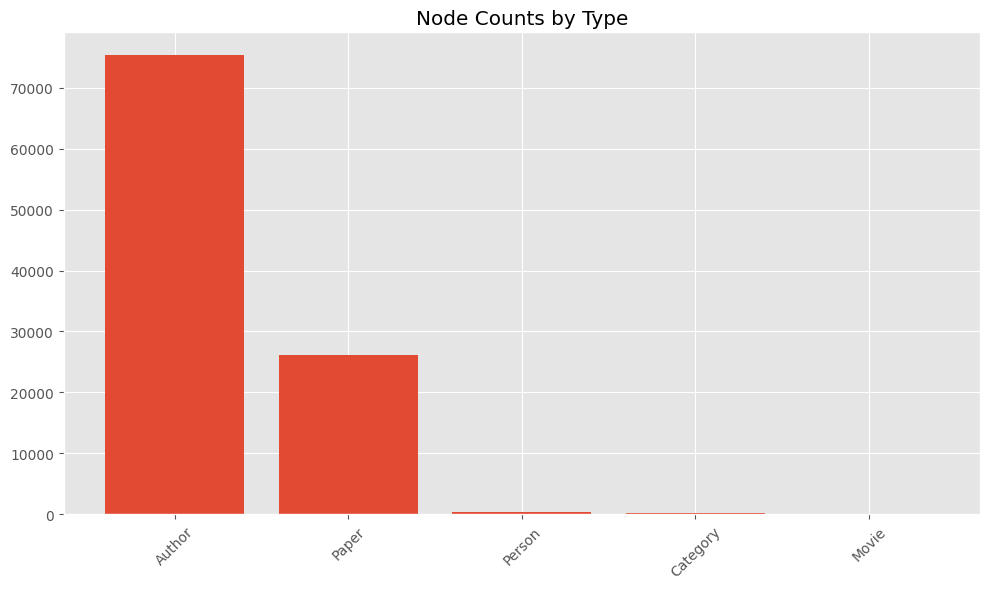

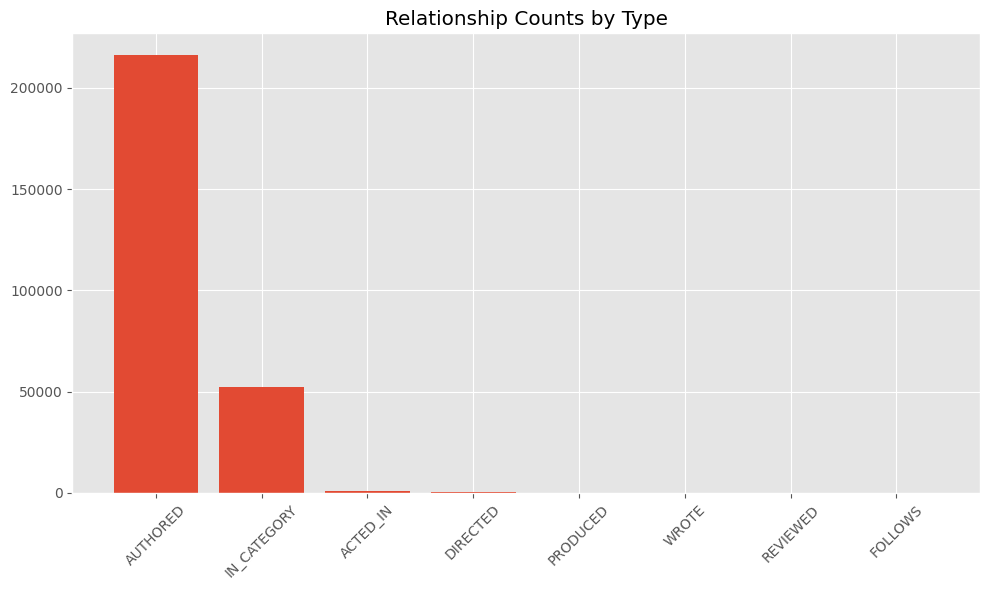

In [80]:
# If connection was successful, get database statistics
if neo4j_driver:
    try:
        with neo4j_driver.session() as session:
            # Count nodes by label
            node_count_query = """
            MATCH (n)
            RETURN labels(n) AS label, count(n) AS count
            ORDER BY count DESC
            """
            node_counts = session.run(node_count_query)
            
            print("Node counts by type:")
            node_data = []
            for record in node_counts:
                label = record["label"][0] if record["label"] else "(no label)"
                count = record["count"]
                print(f"- {label}: {count} nodes")
                node_data.append({"Label": label, "Count": count})
            
            # Count relationships by type
            rel_count_query = """
            MATCH ()-[r]-()
            RETURN type(r) AS type, count(r) AS count
            ORDER BY count DESC
            """
            rel_counts = session.run(rel_count_query)
            
            print("\nRelationship counts by type:")
            rel_data = []
            for record in rel_counts:
                rel_type = record["type"] if record["type"] else "(no type)"
                count = record["count"]
                print(f"- {rel_type}: {count} relationships")
                rel_data.append({"Type": rel_type, "Count": count})
            
            # Create DataFrames for visualization if data exists
            if node_data:
                node_df = pd.DataFrame(node_data)
                plt.figure(figsize=(10, 6))
                plt.bar(node_df['Label'], node_df['Count'])
                plt.title('Node Counts by Type')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            
            if rel_data:
                rel_df = pd.DataFrame(rel_data)
                plt.figure(figsize=(10, 6))
                plt.bar(rel_df['Type'], rel_df['Count'])
                plt.title('Relationship Counts by Type')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    except Exception as e:
        print(f"Error exploring Neo4j: {e}")

## 3. Qdrant Connectivity Test

Finally, let's test the connection to Qdrant, which is used for vector embeddings and semantic search.

In [81]:
def test_qdrant_connection():
    """Test connection to Qdrant and return client if successful"""
    try:
        # Create a Qdrant client
        client = QdrantClient(host=QDRANT_URI, port=QDRANT_PORT)
        
        # Check connection using different methods based on client version
        try:
            # For newer versions, try this API
            collections = client.get_collections()
            print(f"✅ Successfully connected to Qdrant")
            
            # Try to get version info if possible
            try:
                # This might work in some versions
                version = client.openapi_client.get_version()
                print(f"Qdrant version: {version}")
            except:
                try:
                    # Or try this for other versions
                    version_info = client.get_version()
                    print(f"Qdrant version: {version_info}")
                except:
                    print("Qdrant version info not available with this client version")
            
            return client
        except Exception as inner_e:
            print(f"❌ Connected to Qdrant but API check failed: {inner_e}")
            # Still return the client if basic connection worked
            return client
            
    except Exception as e:
        print(f"❌ Failed to connect to Qdrant: {e}")
        return None

# Test Qdrant connection
qdrant_client = test_qdrant_connection()

✅ Successfully connected to Qdrant
Qdrant version info not available with this client version


In [82]:
# If connection was successful, list collections
if qdrant_client:
    try:
        # List collections
        collections = qdrant_client.get_collections().collections
        
        if collections:
            print("Available collections:")
            for collection in collections:
                print(f"- {collection.name}")
                
                # Get collection info
                try:
                    collection_info = qdrant_client.get_collection(collection.name)
                    print(f"  - Vector size: {collection_info.config.params.vectors.size}")
                    print(f"  - Distance: {collection_info.config.params.vectors.distance}")
                    print(f"  - Points count: {collection_info.vectors_count}")
                except Exception as e:
                    print(f"  - Error getting collection info: {e}")
        else:
            print("No collections found. This might be expected if you haven't added vector embeddings yet.")
            
    except Exception as e:
        print(f"Error exploring Qdrant: {e}")

Available collections:
- arxiv_papers
  - Vector size: 384
  - Distance: Cosine
  - Points count: None


## Connection Status Summary

Let's summarize our database connection tests.

In [84]:
# Create a summary of database connections
connection_status = {
    "MongoDB": "Connected" if mongo_client else "Failed",
    "Neo4j": "Connected" if neo4j_driver else "Failed",
    "Qdrant": "Connected" if qdrant_client else "Failed"
}

# Create a DataFrame for better display
status_df = pd.DataFrame(list(connection_status.items()), columns=['Database', 'Status'])
status_df

,Database,Status
0,MongoDB,Connected
1,Neo4j,Connected
2,Qdrant,Connected


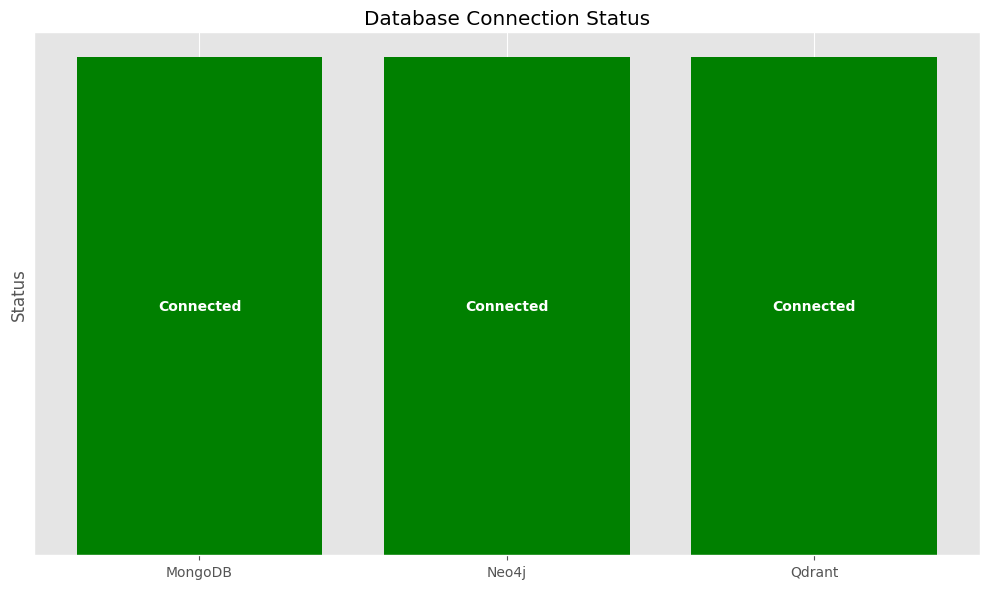


Test completed at: 2025-05-04 15:15:55


In [85]:
# Visualize connection status
plt.figure(figsize=(10, 6))
colors = ['green' if status == 'Connected' else 'red' for status in status_df['Status']]
plt.bar(status_df['Database'], [1] * len(status_df), color=colors)
plt.title('Database Connection Status')
plt.ylabel('Status')
plt.yticks([])

# Add status labels
for i, status in enumerate(status_df['Status']):
    plt.text(i, 0.5, status, ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nTest completed at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

## Cleanup

Close all database connections properly before ending the session.

In [86]:
# Close MongoDB connection
if mongo_client:
    mongo_client.close()
    print("MongoDB connection closed")

# Close Neo4j connection
if neo4j_driver:
    neo4j_driver.close()
    print("Neo4j connection closed")

# Qdrant client doesn't require explicit closing
print("All connections closed properly")

MongoDB connection closed
Neo4j connection closed
All connections closed properly
